In [ ]:
import os
import time
import datetime
from typing import Literal, Optional

import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax

import numpy as np 
import matplotlib.pyplot as plt
from ml_collections import ConfigDict
from chainconsumer import Chain, ChainConsumer, Truth
from tensorflow_probability.substrates.jax.distributions import Distribution

from configs import (
    cumulants_config, get_results_dir, get_posteriors_dir, 
    get_cumulants_sbi_args, get_ndes_from_config
)
from cumulants import (
    CumulantsDataset, Dataset, get_data, get_prior, 
    get_compression_fn, get_datavector, get_linearised_data
)

from sbiax.utils import make_df, marker
from sbiax.ndes import Scaler, CNF, MAF 
from cumulants_ensemble import Ensemble
from sbiax.train import train_ensemble
from sbiax.inference import nuts_sample

from affine import affine_sample
from utils import plot_moments, plot_latin_moments, plot_summaries, plot_fisher_summaries

/Users/Jed.Homer/phd/sbiaxpdf/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Config

In [2]:
def cumulants_config(
    seed: int = 0, 
    redshift: float = 0., 
    reduced_cumulants: bool = False,
    sbi_type: Literal["nle", "npe"] = "nle", 
    linearised: bool = True, 
    compression: Literal["linear", "nn"] = "linear",
    order_idx: list[int] = [0, 1, 2],
    # nonlinearised: bool = True, 
    n_linear_sims: Optional[int] = None,
    pre_train: bool = False
) -> ConfigDict:

    config = ConfigDict()

    config.seed               = seed # For argparse script running without args!

    # Data
    config.dataset_name       = "reduced cumulants" if reduced_cumulants else "cumulants" 
    config.redshift           = redshift
    config.scales             = [5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0]
    config.order_idx          = order_idx # Maximum index is 2
    config.compression        = compression
    config.linearised         = linearised
    config.covariance_epsilon = None # 1e-6
    config.reduced_cumulants  = reduced_cumulants
    config.pre_train          = pre_train and (not linearised)
    config.n_linear_sims      = n_linear_sims # This is for pre-train or linearised simulations 
    config.use_expectation    = False # Noiseless datavector
    config.valid_fraction     = 0.1

    # Miscallaneous
    config.use_scalers        = True # Input scalers for (xi, pi) in NDEs (NOTE: checked that scalings aren't optimised!)
    config.use_pca            = False # Need to add this into other scripts...
    config.ema_rate           = 0.995
    config.use_ema            = False # Use it and sample with it

    # SBI
    config.sbi_type           = sbi_type

    # Experiments
    config.exp_name           = "z={}_m={}".format(config.redshift, "".join(map(str, config.order_idx)))

    # Posterior sampling
    config.n_steps            = 200
    config.n_walkers          = 1000
    config.burn               = int(0.1 * config.n_steps)

    if config.linearised:
        # NDEs
        config.cnf = cnf = ConfigDict()
        cnf.model_type       = "cnf"
        cnf.width_size       = 8
        cnf.depth            = 0
        cnf.activation       = "tanh"
        cnf.dropout_rate     = 0.
        cnf.dt               = 0.1
        cnf.t1               = 1.
        cnf.solver           = "Euler" 
        cnf.exact_log_prob   = True
        cnf.use_scaling      = True # Defaults to (mu, std) of (x, y)

        config.maf = maf = ConfigDict()
        maf.model_type       = "maf" # = model.__class__.__name__
        maf.width_size       = 32
        maf.n_layers         = 2
        maf.nn_depth         = 2
        maf.activation       = "tanh"
        maf.use_scaling      = True # Defaults to (mu, std) of (x, y)

        config.ndes          = [cnf]#, cnf, cnf]  
        config.n_ndes        = len(config.ndes)

        # Optimisation hyperparameters (same for all NDEs...)
        config.train = train = ConfigDict()
        train.start_step     = 0
        train.n_epochs       = 10_000
        train.n_batch        = 100 
        train.patience       = 100
        train.lr             = 1e-3
        train.opt            = "adam" 
        train.opt_kwargs     = {}
    else:
        # NDEs
        config.cnf = cnf = ConfigDict()
        cnf.model_type       = "cnf"
        cnf.width_size       = 8
        cnf.depth            = 0
        cnf.activation       = "tanh"
        cnf.dropout_rate     = 0.
        cnf.dt               = 0.1
        cnf.t1               = 1.
        cnf.solver           = "Euler"
        cnf.exact_log_prob   = True
        cnf.use_scaling      = True # Defaults to (mu, std) of (x, y)

        config.maf = maf = ConfigDict()
        maf.model_type       = "maf" # = model.__class__.__name__
        maf.width_size       = 32
        maf.n_layers         = 8
        maf.nn_depth         = 2
        maf.activation       = "tanh"
        maf.use_scaling      = True # Defaults to (mu, std) of (x, y)

        config.ndes          = [cnf]#, cnf, cnf] #maf, maf, maf]  
        config.n_ndes        = len(config.ndes)

        # Optimisation hyperparameters (same for all NDEs...)
        config.pretrain = pretrain = ConfigDict()
        pretrain.start_step  = 0
        pretrain.n_epochs    = 10_000
        pretrain.n_batch     = 100 
        pretrain.patience    = 10
        pretrain.lr          = 1e-3
        pretrain.opt         = "adam" 
        pretrain.opt_kwargs  = {}

        config.train = train = ConfigDict()
        train.start_step     = 0
        train.n_epochs       = 10_000
        train.n_batch        = 100 
        train.patience       = 10
        train.lr             = 1e-3
        train.opt            = "adam" 
        train.opt_kwargs     = {}

    return config

In [3]:
t0 = time.time()

print("TIME:", datetime.datetime.now().strftime("%H:%M %d-%m-%y"))

args = ConfigDict()
args.seed                = 0
args.redshift            = 0.
args.sbi_type            = "nle"
args.linearised          = False
args.reduced_cumulants   = True
args.compression         = "linear"
args.order_idx           = [0]
args.pre_train           = True and (not args.linearised)
args.n_linear_sims       = 5_000 #if args.linearised else 10_000

config = cumulants_config(**args)

args.verbose             = False
args.use_tqdm            = True

key = jr.key(config.seed)

( 
    model_key, train_key, key_prior, 
    key_datavector, key_state, key_sample
) = jr.split(key, 6)

results_dir = get_results_dir(config, args)

posteriors_dir = get_posteriors_dir(config)

cumulants_dataset: CumulantsDataset = CumulantsDataset(config, results_dir=results_dir)

dataset: Dataset = cumulants_dataset.data
parameter_prior: Distribution = cumulants_dataset.prior

print("DATA:", ["{:.3E} {:.3E}".format(_.min(), _.max()) for _ in (dataset.fiducial_data, dataset.data)])
print("DATA:", [_.shape for _ in (dataset.fiducial_data, dataset.data)])

TIME: 13:06 14-03-25
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/sbiax/results/reduced_cumulants/nle/nonlinearised/linear/pretrain/z=0.0_m=0/0/
RESULTS_DIR:
 /Users/Jed.Homer/phd/sbiaxpdf/sbiax/results/posteriors/reduced_cumulants/nle/nonlinearised/linear/pretrain/z=0.0_m=0/0/
Using flat prior
DATA: ['5.060E-02 1.950E+00', '1.383E-02 6.459E+00']
DATA: [(15000, 7), (2000, 7)]


Compression

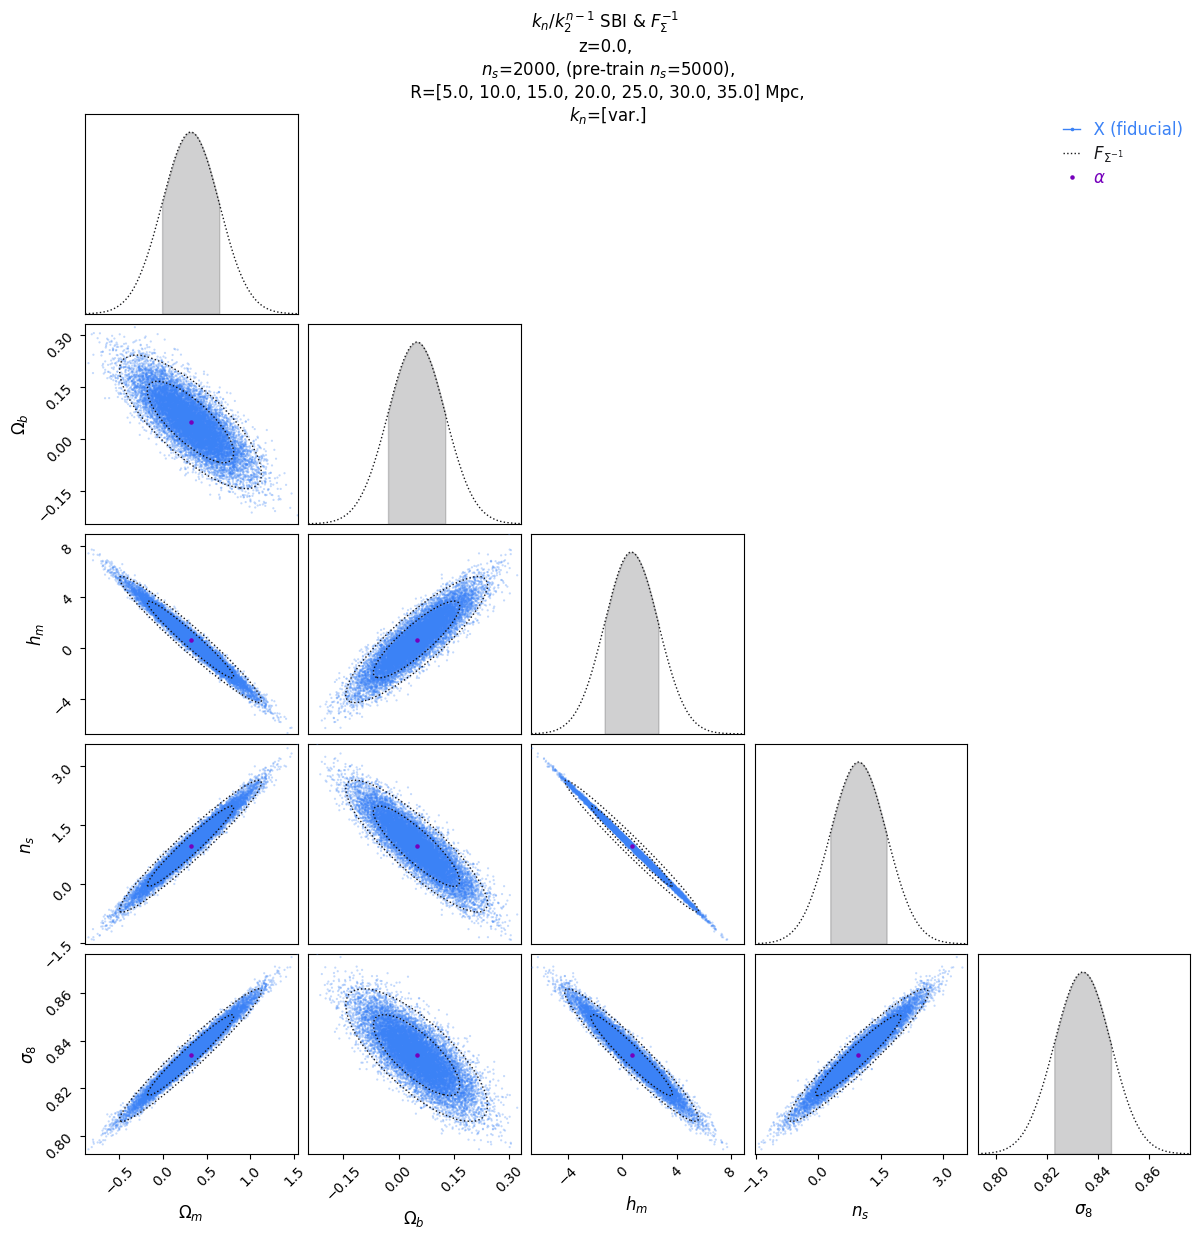

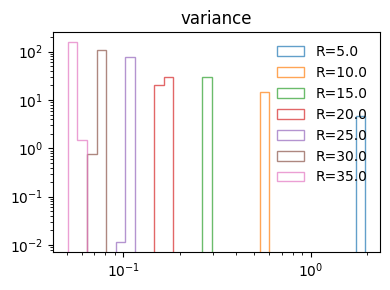

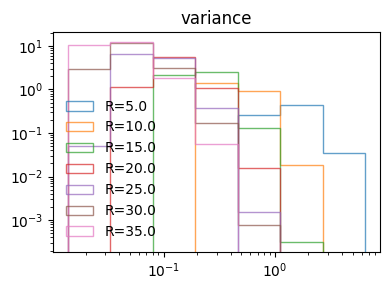

In [4]:
# Compress simulations
compression_fn = cumulants_dataset.compression_fn

X = jax.vmap(compression_fn)(dataset.data, dataset.parameters)

# Fiducial
X0 = jax.vmap(compression_fn, in_axes=(0, None))(dataset.fiducial_data, dataset.alpha)

c = ChainConsumer()
c.add_chain(
    Chain(
        samples=make_df(X0, parameter_strings=dataset.parameter_strings), 
        name="X (fiducial)", 
        color="b", 
        plot_contour=False, 
        plot_cloud=True
    )
)
c.add_chain(
    Chain.from_covariance(
        dataset.alpha,
        dataset.Finv,
        columns=dataset.parameter_strings,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        linestyle=":",
        shade_alpha=0.
    )
)
# c.add_chain(
#     Chain(
#         samples=make_df(dataset.parameters, parameter_strings=dataset.parameter_strings), 
#         plot_contour=False, 
#         plot_cloud=True, 
#         name="P", 
#         color="r"
#     )
# )
c.add_marker(
    location=marker(dataset.alpha, parameter_strings=dataset.parameter_strings),
    name=r"$\alpha$", 
    color="#7600bc"
)
fig = c.plotter.plot()
fig.suptitle(
    r"$k_n/k_2^{n-1}$ SBI & $F_{{\Sigma}}^{{-1}}$" + "\n" +
    "z={},\n $n_s$={}, (pre-train $n_s$={}),\n R={} Mpc,\n $k_n$={}".format(
            config.redshift, 
            len(X), 
            config.n_linear_sims if config.pre_train else None,
            "[{}]".format(", ".join(map(str, config.scales))),
            "[{}]".format(",".join(map(str, [["var.", "skew.", "kurt."][_] for _ in config.order_idx])))
        ),
    multialignment='center'
)
plt.show()

# Plot summaries
# plot_summaries(X, dataset.parameters, dataset)

plot_moments(dataset.fiducial_data, config)

plot_latin_moments(dataset.data, config)

NDEs

In [5]:
def replace_scalers(ensemble, *, X, P):
    is_scaler = lambda x: isinstance(x, Scaler)
    get_scalers = lambda m: [
        x
        for x in jax.tree.leaves(m, is_leaf=is_scaler)
        if is_scaler(x)
    ]
    ensemble = eqx.tree_at(
        get_scalers, 
        ensemble, 
        [Scaler(X, P)] * sum(int(nde.use_scaling) for nde in config.ndes) 
    )
    return ensemble

In [6]:
scaler = Scaler(X, dataset.parameters, use_scaling=config.use_scalers)

ndes = get_ndes_from_config(
    config, 
    event_dim=dataset.alpha.size, 
    scalers=scaler, # Same scaler for all NDEs 
    use_scalers=config.use_scalers,
    key=model_key
)

# print("scaler:", ndes[0].scaler.mu_x if ndes[0].scaler is not None else None)

ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

data_preprocess_fn = lambda x: x# jnp.log(jnp.clip(x, min=1e-10)) 

Linearised pre-training...
Hypercube sampling...
Get linearised data (5000, 7) (5000, 5)
Pre-training with (5000, 7) (5000, 5) (5000, 5)
NDE has n_params=115.


Training terminated early at epoch 138; valid=-7.937E+00, train=-8.067E+00.:   1%|▏         | 137/10000 [00:20<24:06,  6.82epoch/s, t=-8.067E+00 | v=-7.937E+00 | v(best)=-8.075E+00 | stop=0000]


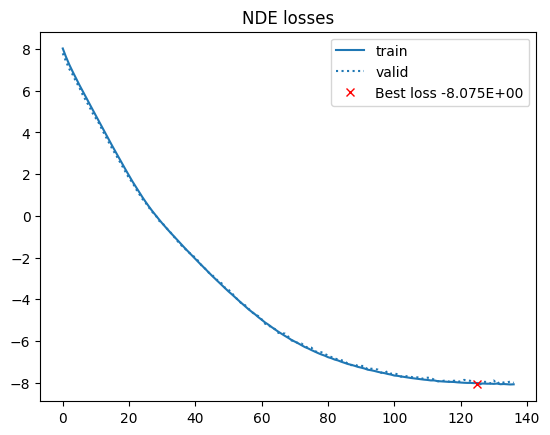

Weights: [1.]


Sampling: 100%|██████████| 220/220 [01:21<00:00,  2.71it/s]


In [7]:
# Only pre-train if required and not inferring from linear simulations
if (
    (not config.linearised) 
    and config.pre_train 
    and (config.n_linear_sims is not None)
):
    print("Linearised pre-training...")

    pre_train_key, summaries_key = jr.split(key)

    # Pre-train data = linearised simulations
    D_l, Y_l = cumulants_dataset.get_linearised_data()

    X_l = jax.vmap(compression_fn)(D_l, Y_l)

    print("Pre-training with", D_l.shape, X_l.shape, Y_l.shape)

    plot_fisher_summaries(X_l, Y_l, dataset, results_dir)

    opt = getattr(optax, config.pretrain.opt)(config.pretrain.lr)

    if config.use_scalers:
        ensemble = replace_scalers(
            ensemble, X=data_preprocess_fn(X_l), P=dataset.parameters
        )

    ensemble, stats = train_ensemble(
        pre_train_key, 
        ensemble,
        train_mode=config.sbi_type,
        train_data=(data_preprocess_fn(X_l), Y_l), 
        opt=opt,
        use_ema=config.use_ema,
        ema_rate=config.ema_rate,
        n_batch=config.pretrain.n_batch,
        patience=config.pretrain.patience,
        n_epochs=config.pretrain.n_epochs,
        valid_fraction=config.valid_fraction,
        tqdm_description="Training (pre-train)",
        show_tqdm=args.use_tqdm,
        # results_dir=results_dir
    )

    # Test pre-training on a linearised datavector...
    datavector = jr.multivariate_normal(
        key, 
        jnp.mean(dataset.fiducial_data, axis=0), 
        dataset.C
    )

    x_ = compression_fn(datavector, dataset.alpha)

    log_prob_fn = ensemble.ensemble_log_prob_fn(data_preprocess_fn(x_), parameter_prior)

    state = jr.multivariate_normal(
        key_state, x_, dataset.Finv, (2 * config.n_walkers,)
    )

    samples, weights = affine_sample(
        key_sample, 
        log_prob=log_prob_fn,
        n_walkers=config.n_walkers, 
        n_steps=config.n_steps + config.burn, 
        burn=config.burn, 
        current_state=state,
        description="Sampling",
        show_tqdm=args.use_tqdm
    )

    samples_log_prob = jax.vmap(log_prob_fn)(samples)
    alpha_log_prob = log_prob_fn(jnp.asarray(dataset.alpha))

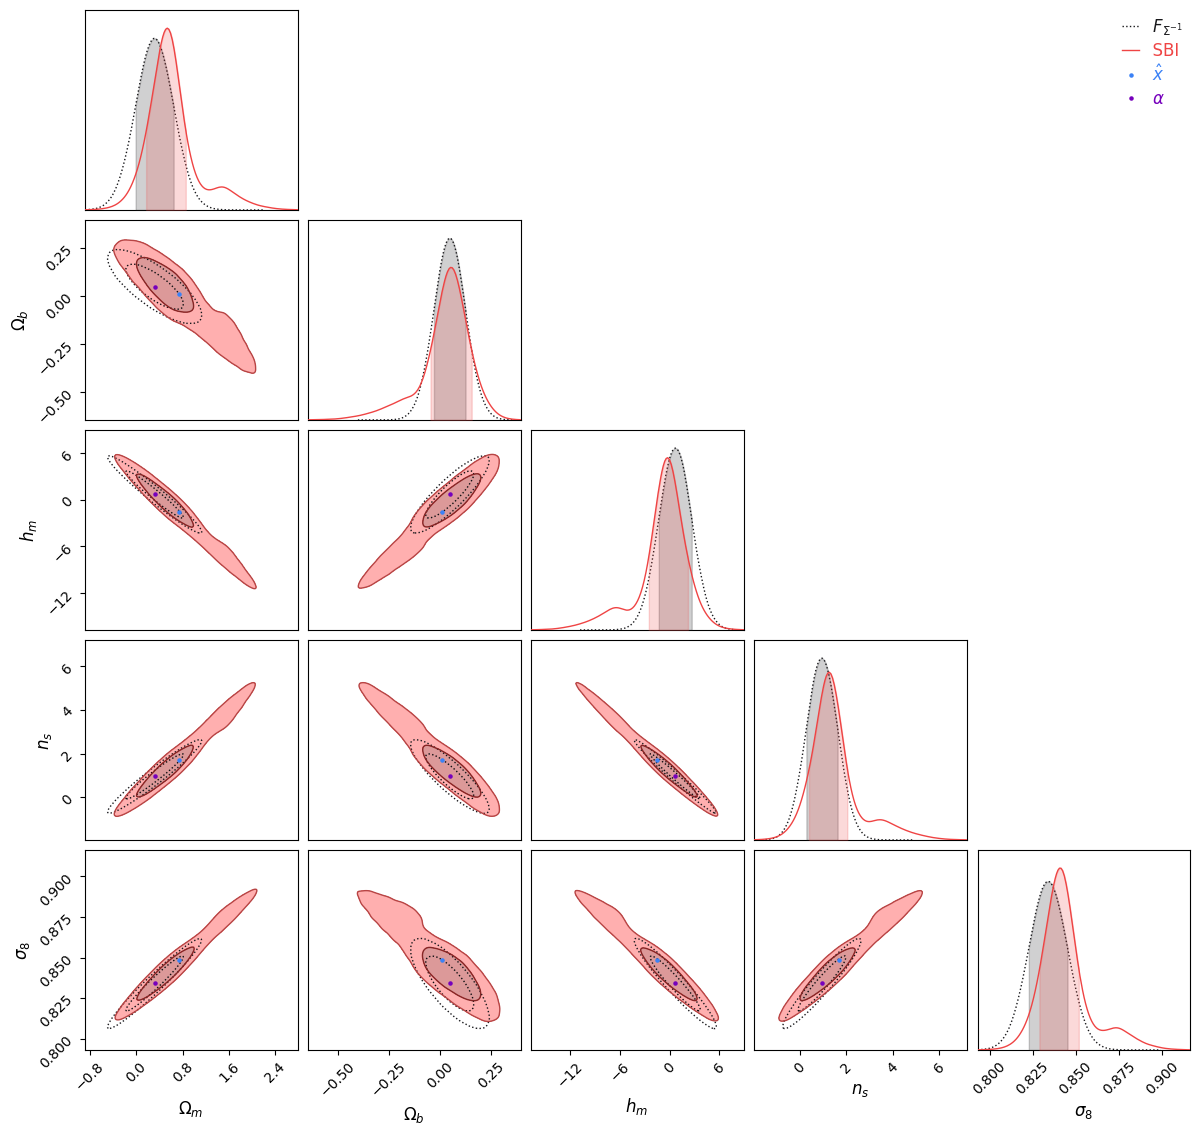

In [8]:
if (
    (not config.linearised) 
    and config.pre_train 
    and (config.n_linear_sims is not None)
):
    posterior_df = make_df(
        samples, 
        samples_log_prob, 
        parameter_strings=dataset.parameter_strings
    )

    np.savez(
        os.path.join(results_dir, "posterior.npz"), 
        alpha=dataset.alpha,
        samples=samples,
        samples_log_prob=samples_log_prob,
        datavector=datavector,
        summary=x_
    )

    c = ChainConsumer()
    c.add_chain(
        Chain.from_covariance(
            dataset.alpha,
            dataset.Finv,
            columns=dataset.parameter_strings,
            name=r"$F_{\Sigma^{-1}}$",
            color="k",
            linestyle=":",
            shade_alpha=0.
        )
    )
    c.add_chain(Chain(samples=posterior_df, name="SBI", color="r"))
    c.add_marker(
        location=marker(x_, parameter_strings=dataset.parameter_strings),
        name=r"$\hat{x}$", 
        color="b"
    )
    c.add_marker(
        location=marker(dataset.alpha, parameter_strings=dataset.parameter_strings),
        name=r"$\alpha$", 
        color="#7600bc"
    )
    fig = c.plotter.plot()
    plt.savefig(os.path.join(results_dir, "posterior_affine_pretrain.pdf"))
    plt.savefig(os.path.join(posteriors_dir, "posterior_affine_pretrain.pdf"))
    plt.show()

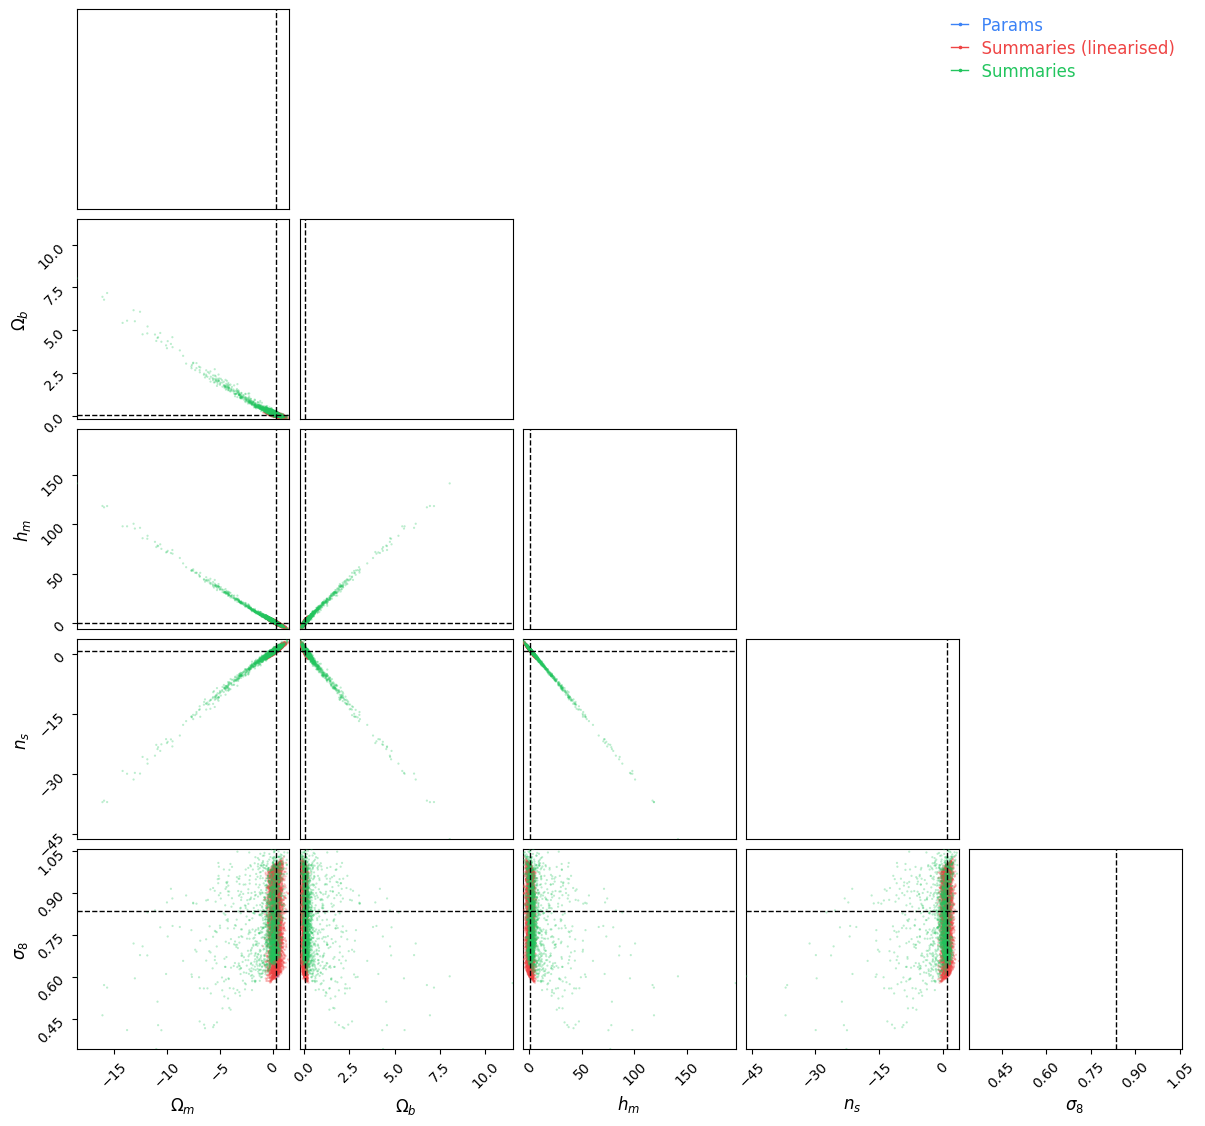

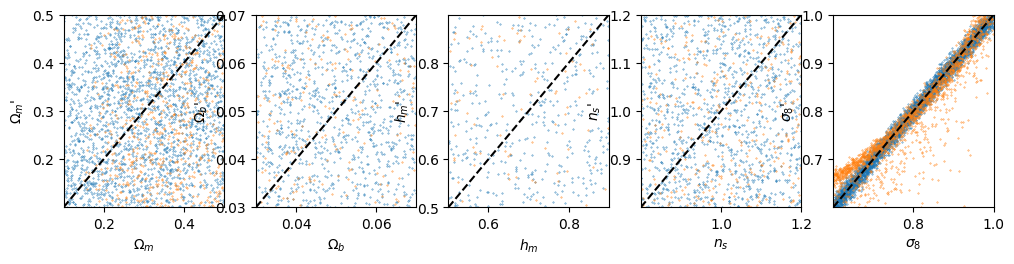

In [9]:
if (not args.linearised) and args.pre_train:
    c = ChainConsumer()
    c.add_chain(
        Chain(
            samples=make_df(dataset.parameters, parameter_strings=dataset.parameter_strings), 
            name="Params", 
            color="blue", 
            plot_cloud=True, 
            plot_contour=False
        )
    )
    c.add_chain(
        Chain(
            samples=make_df(X_l, parameter_strings=dataset.parameter_strings), 
            name="Summaries (linearised)", 
            color="red", 
            plot_cloud=True, 
            plot_contour=False
        )
    )
    c.add_chain(
        Chain(
            samples=make_df(X, parameter_strings=dataset.parameter_strings),
            name="Summaries", 
            color="green", 
            plot_cloud=True, 
            plot_contour=False
        )
    )
    c.add_truth(
        Truth(location=dict(zip(dataset.parameter_strings, dataset.alpha)), name=r"$\pi^0$")
    )
    fig = c.plotter.plot()
    plt.show()

    fig, axs = plt.subplots(1, dataset.alpha.size, figsize=(2. + 2. * dataset.alpha.size, 2.5))
    for p, ax in enumerate(axs):
        ax.scatter(Y_l[:, p], X_l[:, p], s=0.1)
        ax.scatter(dataset.parameters[:, p], X[:, p], s=0.1)
        ax.axline((0, 0), slope=1., color="k", linestyle="--")
        ax.set_xlim(dataset.lower[p], dataset.upper[p])
        ax.set_ylim(dataset.lower[p], dataset.upper[p])
        ax.set_xlabel(dataset.parameter_strings[p])
        ax.set_ylabel(dataset.parameter_strings[p] + "'")
    plt.show()

NDE on simulation

Data / Parameters [(2000, 5), (2000, 5)]
Data / Parameters [(Array(-63.783237, dtype=float32), Array(196.29797, dtype=float32)), (Array(0.03001, dtype=float32), Array(1.1999, dtype=float32))]
NDE has n_params=115.


Training terminated early at epoch 132; valid=-5.162E+00, train=-5.833E+00.:   1%|▏         | 131/10000 [00:08<10:24, 15.81epoch/s, t=-5.833E+00 | v=-5.162E+00 | v(best)=-5.480E+00 | stop=0000]


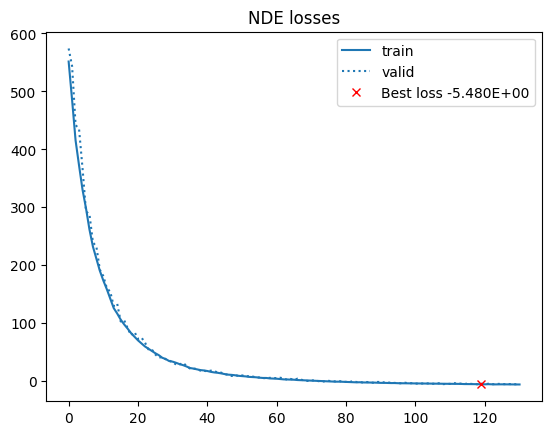

Weights: [1.]


In [10]:
opt = getattr(optax, config.train.opt)(config.train.lr)

print("Data / Parameters", [_.shape for _ in (X, dataset.parameters)])
print("Data / Parameters", [(jnp.min(X), jnp.max(X)), (jnp.min(dataset.parameters), jnp.max(dataset.parameters))])

if config.use_scalers:
    ensemble = replace_scalers(
        ensemble, X=data_preprocess_fn(X), P=dataset.parameters
    )

ensemble, stats = train_ensemble(
    train_key, 
    ensemble,
    train_mode=config.sbi_type,
    train_data=(data_preprocess_fn(X), dataset.parameters), 
    opt=opt,
    use_ema=config.use_ema,
    ema_rate=config.ema_rate,
    n_batch=config.train.n_batch,
    patience=config.train.patience,
    n_epochs=config.train.n_epochs,
    valid_fraction=config.valid_fraction,
    tqdm_description="Training (data)",
    show_tqdm=args.use_tqdm,
    # results_dir=results_dir
)

# print("scaler:", ndes[0].scaler.mu_x if ndes[0].scaler is not None else None)

In [11]:
ensemble = eqx.nn.inference_mode(ensemble)

# Generates linearised (or not) datavector at fiducial parameters
datavector = cumulants_dataset.get_datavector(key_datavector)

x_ = compression_fn(datavector, dataset.alpha)

print("datavector", x_, dataset.alpha)

log_prob_fn = ensemble.ensemble_log_prob_fn(data_preprocess_fn(x_), parameter_prior)

state = jr.multivariate_normal(
    key_state, x_, dataset.Finv, (2 * config.n_walkers,)
)

samples, weights = affine_sample(
    key_sample, 
    log_prob=log_prob_fn,
    n_walkers=config.n_walkers, 
    n_steps=config.n_steps + config.burn, 
    burn=config.burn, 
    current_state=state,
    description="Sampling",
    show_tqdm=args.use_tqdm
)

samples_log_prob = jax.vmap(log_prob_fn)(samples)
alpha_log_prob = log_prob_fn(jnp.asarray(dataset.alpha))

np.savez(
    os.path.join(results_dir, "posterior.npz"), 
    alpha=dataset.alpha,
    samples=samples,
    samples_log_prob=samples_log_prob,
    datavector=datavector,
    summary=x_
)

Using non-linearised datavector
datavector [0.45803654 0.10679594 0.47452295 1.0135255  0.84225965] [0.3175 0.049  0.6711 0.9624 0.834 ]


Sampling: 100%|██████████| 220/220 [00:49<00:00,  4.44it/s]


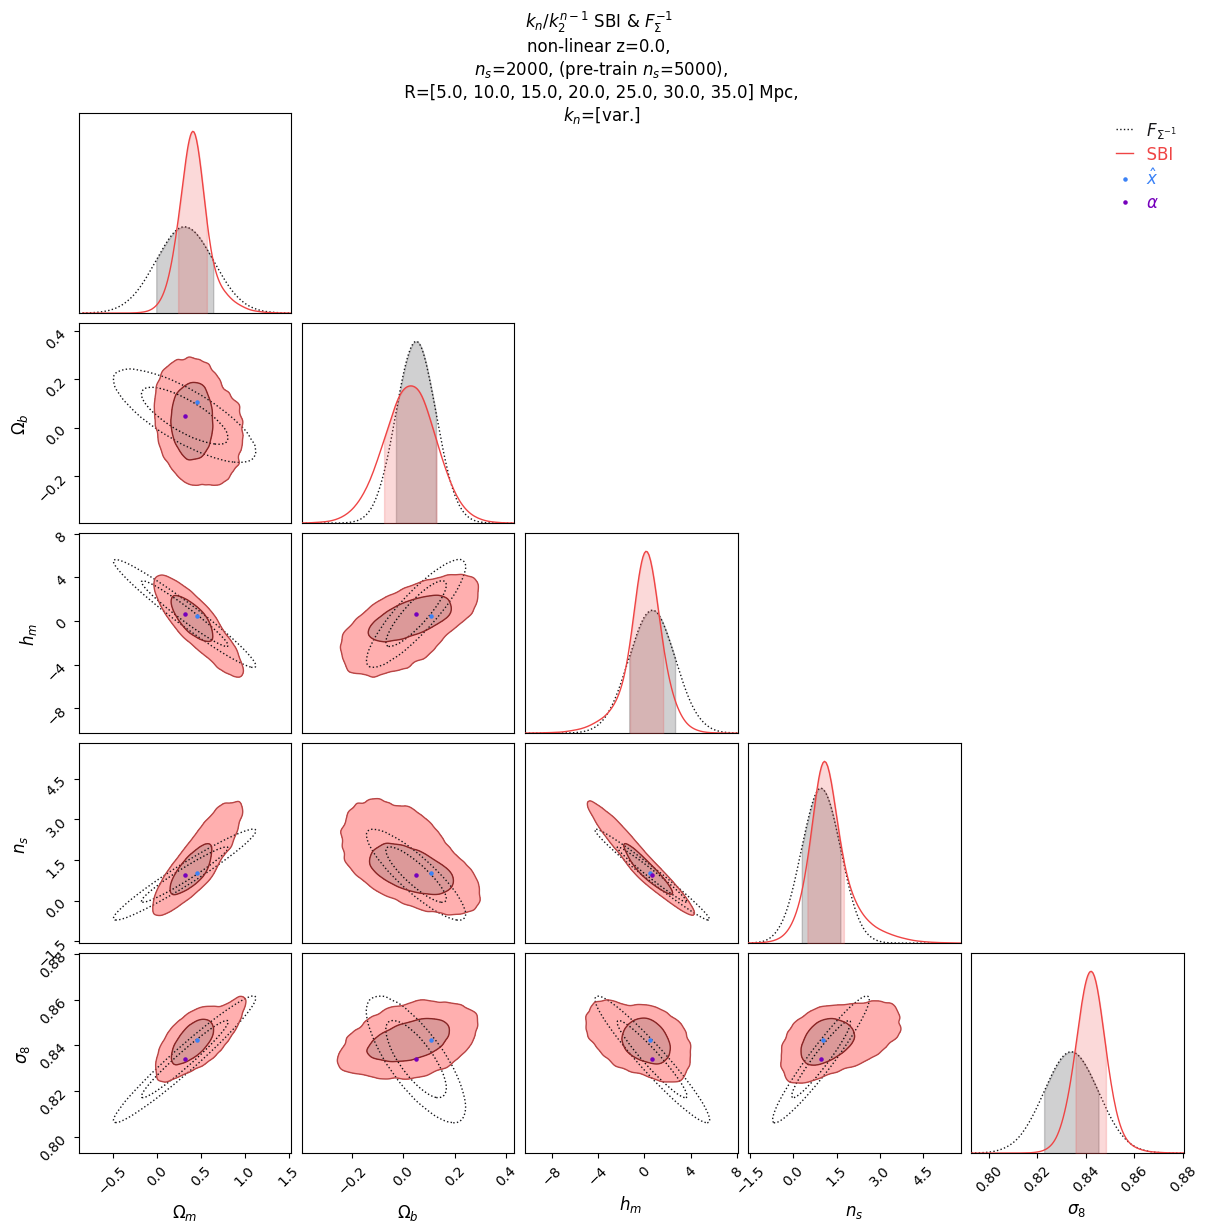

In [ ]:
posterior_df = make_df(
    samples, 
    samples_log_prob, 
    parameter_strings=dataset.parameter_strings
)

c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(
        dataset.alpha,
        dataset.Finv,
        columns=dataset.parameter_strings,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        linestyle=":",
        shade_alpha=0.
    )
)
c.add_chain(Chain(samples=posterior_df, name="SBI", color="r"))
c.add_marker(
    location=marker(x_, parameter_strings=dataset.parameter_strings),
    name=r"$\hat{x}$", 
    color="b"
)
c.add_marker(
    location=marker(dataset.alpha, parameter_strings=dataset.parameter_strings),
    name=r"$\alpha$", 
    color="#7600bc"
)
fig = c.plotter.plot()
fig.suptitle(
    r"{} SBI & $F_{{\Sigma}}^{{-1}}$".format("$k_n/k_2^{n-1}$" if config.reduced_cumulants else "$k_n$") + "\n" +
    "{} z={},\n $n_s$={}, (pre-train $n_s$={}),\n R={} Mpc,\n $k_n$={}".format(
            ("linearised" if config.linearised else "non-linear") + "\n",
            config.redshift, 
            len(X), 
            config.n_linear_sims if config.pre_train else None,
            "[{}]".format(", ".join(map(str, config.scales))),
            "[{}]".format(", ".join(map(str, [["var.", "skew.", "kurt."][_] for _ in config.order_idx])))
        ),
    multialignment='center'
)
plt.show()
# plt.savefig(os.path.join(results_dir, "posterior_affine.pdf"))
# plt.savefig(os.path.join(posteriors_dir, "posterior_affine.pdf"))
# plt.close()

In [13]:
# X.min(), X.max()
# jnp.log(jnp.clip(X, a=1e-5)).min(), jnp.log(jnp.clip(X, a=1e-5)).max()

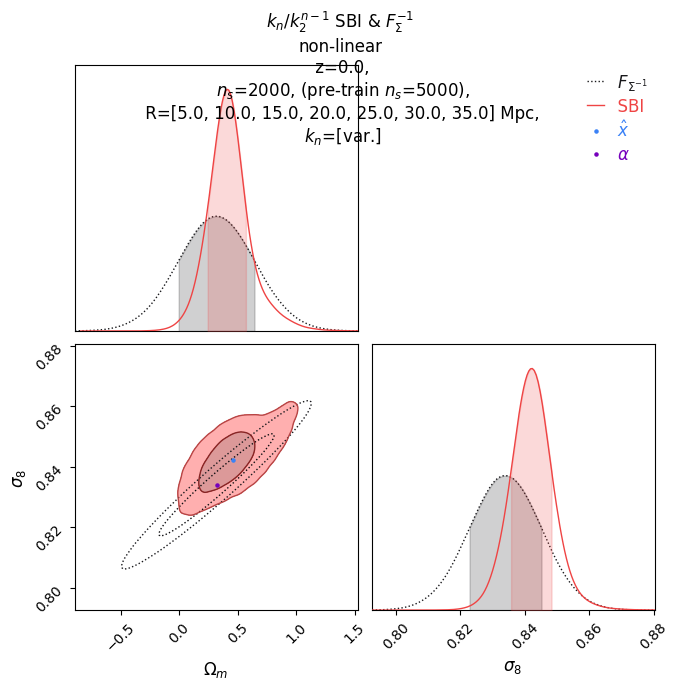

In [16]:
Om_s8_idx = np.array([0, -1])
posterior_df = make_df(
    samples[:, Om_s8_idx], 
    samples_log_prob, 
    parameter_strings=[dataset.parameter_strings[p] for p in Om_s8_idx]
)

c = ChainConsumer()
c.add_chain(
    Chain.from_covariance(
        dataset.alpha[Om_s8_idx],
        dataset.Finv[:, Om_s8_idx][Om_s8_idx, :],
        columns=[dataset.parameter_strings[p] for p in Om_s8_idx],
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        linestyle=":",
        shade_alpha=0.
    )
)
c.add_chain(Chain(samples=posterior_df, name="SBI", color="r"))
c.add_marker(
    location=marker(x_[Om_s8_idx], parameter_strings=[dataset.parameter_strings[p] for p in Om_s8_idx]),
    name=r"$\hat{x}$", 
    color="b"
)
c.add_marker(
    location=marker(dataset.alpha[Om_s8_idx], parameter_strings=[dataset.parameter_strings[p] for p in Om_s8_idx]),
    name=r"$\alpha$", 
    color="#7600bc"
)
fig = c.plotter.plot()
fig.suptitle(
    r"{} SBI & $F_{{\Sigma}}^{{-1}}$".format("$k_n/k_2^{n-1}$" if config.reduced_cumulants else "$k_n$") + "\n" +
    "{} z={},\n $n_s$={}, (pre-train $n_s$={}),\n R={} Mpc,\n $k_n$={}".format(
            ("linearised" if config.linearised else "non-linear") + "\n",
            config.redshift, 
            len(X), 
            config.n_linear_sims if config.pre_train else None,
            "[{}]".format(", ".join(map(str, config.scales))),
            "[{}]".format(", ".join(map(str, [["var.", "skew.", "kurt."][_] for _ in config.order_idx])))
        ),
    multialignment='center'
)
plt.show()
# plt.savefig(os.path.join(results_dir, "posterior_affine.pdf"))
# plt.savefig(os.path.join(posteriors_dir, "posterior_affine.pdf"))
# plt.close()